# Using RomanMachine to Compute PRF Photometry

This tutorial notebook shows how to use `RomanMachine` to fit PRF photometry using a pre-compouted PRF model on a _small_ cutout (28x28) pixels.

We start with the basic imports...

In [117]:
import os
import pandas as pd
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from astropy.io import fits

from roman_lcs import RomanMachine, PACKAGEDIR
from roman_lcs.utils import to_fits, clean_blends_in_catalog, _make_A_polar

from roman_cuts import RomanCuts

We will use the PRF model we built in the previous tutorial to fit the photometry of sources in a smaller cutout including fainter sources `<24`.

For this example, we will use simulated images from `RImTimSim` in the F146 band, field 3 and the SCA 2

In [2]:
# change PATH to you local directoy with the images
PATH = "/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01"
FILTER = "F146"
FIELD = 3
SCA = 2

In [200]:
cutout_size = 24
mag_limit = 24

target = 4579395
radec = (268.48744213, -29.2076513)
cutout_origin = (1831, 1797)
blend_limit = 0.1 / 2  # max source distance to remove blends , in arcsec

We load the source catalog, clean blended sources within 0.05'', and rename some columns

In [207]:
catalog = pd.read_csv(f"{PATH}/cutout_sample/TRExS_dryrun_01_MASTER_input_catalog_v1.1_cutout.csv", index_col=0)
query = (
            f"F146 <= {mag_limit} and "
            f"MEAN_XCOL >= {cutout_origin[0] - 2} and MEAN_XCOL <= {cutout_origin[0] + cutout_size + 6} and "
            f"MEAN_YCOL >= {cutout_origin[1] - 2} and MEAN_YCOL <= {cutout_origin[1] + cutout_size + 6}"
        )
catalog = catalog.query(query).reset_index(drop=True)
catalog = catalog.rename(
        columns={
            "RA_DEG": "ra",
            "DEC_DEG": "dec",
            "MEAN_XCOL": "column",
            "MEAN_YCOL": "row",
            f"{FILTER}_flux": "flux",
            f"{FILTER}_flux_err": "flux_err",
        }
    )
catalog = clean_blends_in_catalog(catalog, blend_limit=blend_limit, filter="F146")
catalog

sicbro_id          ra        dec       column          row     F062  \
0         4341  268.487474 -29.207950  1852.748186  1804.661151  25.0783   
1         5080  268.487149 -29.207312  1834.156625  1818.574293  17.2532   
2        44097  268.487545 -29.208134  1857.537822  1800.304811  25.0926   
3       133845  268.487768 -29.207899  1859.256254  1810.580043  22.3539   
4       146695  268.487551 -29.207866  1853.274766  1808.293355  19.7989   
..         ...         ...        ...          ...          ...      ...   
161    4918347  268.486989 -29.207975  1841.046073  1796.638944  19.9131   
162    4919513  268.487292 -29.207918  1847.663371  1802.879069  20.0561   
163    4931714  268.487373 -29.208060  1852.010801  1799.911852  19.7056   
164    4951986  268.486743 -29.207676  1829.978629  1801.768293  19.5486   
165    4956475  268.487041 -29.207632  1836.693103  1807.537959  19.2812   

        F087     F106     F129     F158  ...  lowmassEB  lowRedNoise  \
0    23.5025  22.8282  22.1538  21.9855  ...          0            0   
1    16.9228  16.8509  16.7790  16.8214  ...          0            0   
2    23.6242  23.0172  22.4102  22.2050  ...          0            0   
3    21.5553  21.2295  20.9037  20.6649  ...          0            0   
4    19.2117  19.0778  18.9439  18.9503  ...          0            0   
..       ...      ...      ...      ...  ...        ...          ...   
161  19.3054  19.1620  19.0185  19.0345  ...          0            0   
162  19.5235  19.4030  19.2824  19.3051  ...          0            0   
163  19.0584  18.9046  18.7507  18.7359  ...          0            0   
164  18.8465  18.6748  18.5031  18.4598  ...          0            1   
165  18.5541  18.3140  18.0739  17.9301  ...          0            0   

     hiRedNoise  variable     F087_flux  F087_flux_err          flux  \
0             0         0     41.157280       6.415394    152.730815   
1             0         0  17633.018703     132.789377  18441.942693   
2             0         0     36.793124       6.065734    123.676352   
3             0         0    247.358403      15.727632    492.954310   
4             0         0   2141.739607      46.278933   2588.729473   
..          ...       ...           ...            ...           ...   
161           1         1   1964.656675      44.324448   2406.836939   
162           0         0   1607.113940      40.088826   1873.469677   
163           0         0   2466.531511      49.664187   3137.954688   
164           0         1   2998.103823      54.754943   4016.489798   
165           0         0   3924.701833      62.647441   6313.739629   

       flux_err     F213_flux  F213_flux_err  
0     12.358431    147.695298      12.152995  
1    135.801114  14050.334643     118.534108  
2     11.120987    123.551115      11.115355  
3     22.202574    454.032215      21.308032  
4     50.879558   2084.906907      45.660781  
..          ...           ...            ...  
161   49.059524   1940.200750      44.047710  
162   43.283596   1484.180318      38.525061  
163   56.017450   2574.700208      50.741504  
164   63.375782   3371.682471      58.066190  
165   79.459044   5531.038330      74.370951  

[166 rows x 26 columns]

This 24 x 24 pixels cutout has 179 sources brighter than 24th magnitude

We initialize `RomanMachine` with the input catalog and with all the frames we want to fit. In this example, only half of the season is available. This will take about half a minute, depending on how fast the FITS files are read, how big is the cutout, and how many frames are loaded.

In [208]:
ff = f"{PATH}/cutout_sample/rimtimsim_WFI_lvl02_{FILTER}_SCA{SCA:02}_field{FIELD:02}_rampfitted_r1920c1920_256x256_sim.asdf"

NOTE: Loading from a ASDF file is slower than from single FITS files, this is because for FITS files we can read specific file byte with C. Does ASDF has a similar functionality (i.e. simil to `fitsio`)

In [209]:
mac = RomanMachine.from_file(
    ff,
    sources=catalog,
    sparse_dist_lim=2,
    sources_flux_column="flux",
    cutout_size=cutout_size,
    cutout_center=radec,
)
# we specify flux limit to consider contamination
# this helps get more datapoints to build the model
# in reality we should push this to lower values, but 
# that increases the chances to get an unsolvable
# system of equations
# for this example we use F146 = 21 mag
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

RomanMachine (N sources, N times, N pixels): (166, 6595, 576)

We inspect a frame

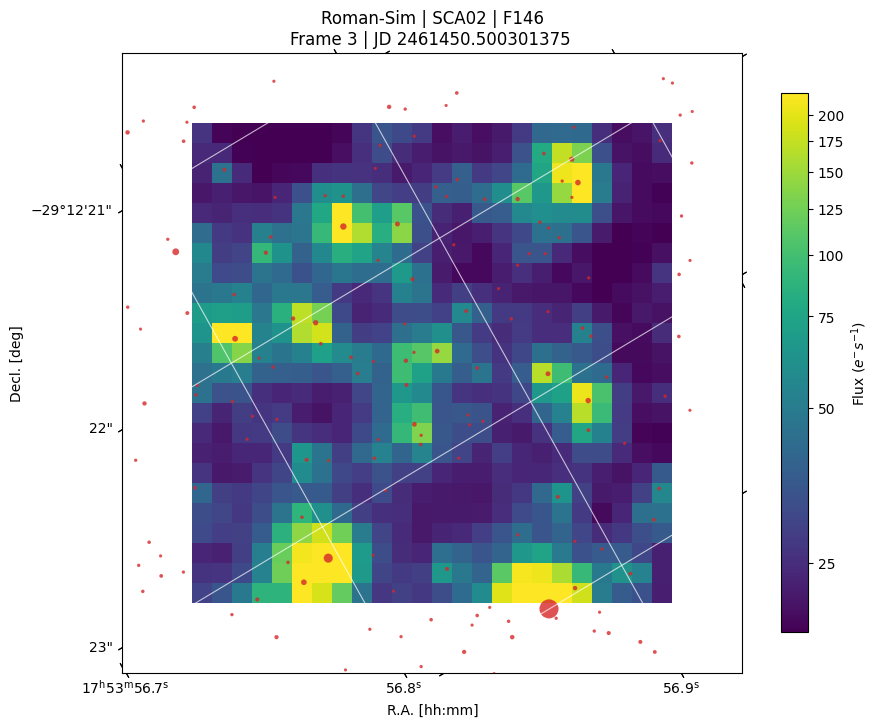

In [210]:
mac.plot_image(sources=True, frame_index=0);

We load the PRF model weights and create the mean models to be used for evaluation

/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


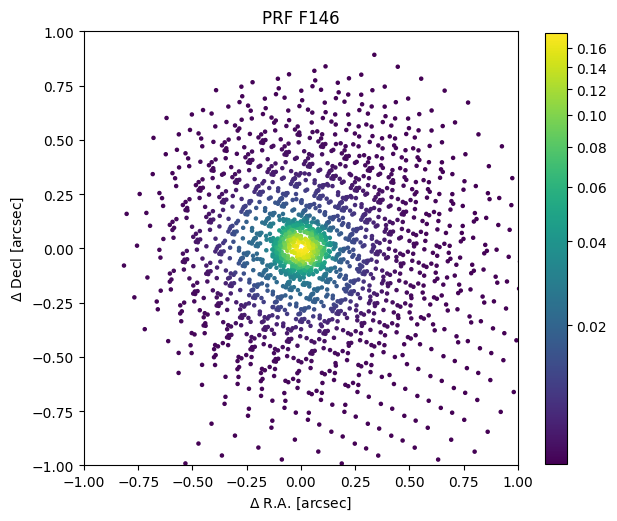

In [211]:
prf_fname = (
        f"{os.path.dirname(os.path.dirname(PACKAGEDIR))}/data/prf_models/"
        f"roman_WFI_{mac.meta['READMODE']}_{mac.meta['FILTER']}"
        f"_{mac.meta['FIELD']}_{mac.meta['DETECTOR']}_shape_model_cad{0}"
        f"_center_v2.fits"
    )

mac.load_shape_model(
            prf_fname, flux_cut_off=0.01, source_flux_limit=5
        )
mac.plot_prf_model(hires=False);

We can also check the dithered offsets in both axis, R.A. and Dec.

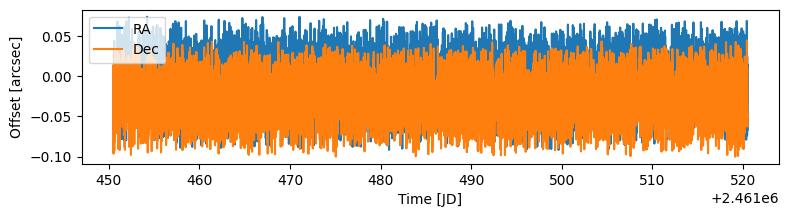

In [247]:
mac._pointing_offset()

plt.figure(figsize=(9,2))
plt.plot(mac.time, mac.ra_offset * 3600, label="RA")
plt.plot(mac.time, mac.dec_offset * 3600, label="Dec")
plt.legend()
plt.xlabel("Time [JD]")
plt.ylabel("Offset [arcsec]")
plt.show()

## Fit single target

We fit a model that has the following components:
 - Fixed background stars
 - Variable background
 - PRF model of the target star
 - Optional PRF model of blended stars

This model ensures we extract the photometry of the target star, it provides better precision but sacrifices accuracy.
This could take from 1 to 10 min depending on the number of frames and computing resources. 

In [212]:
target_idx = catalog.query(f"sicbro_id == {target}").index

mac.fit_prf_photometry(targets=target_idx.tolist(), model_bkg=True)

Fitting PRF photometry:   0%|                                                                         | 0/6595 [00:00<?, ?it/s]/Users/jimartin/Work/ROMAN/TRExS/Roman-lcs/src/roman_lcs/utils.py:328: RuntimeWarning: invalid value encountered in sqrt
  w_err = np.linalg.inv(sigma_w_inv).diagonal() ** 0.5
Fitting PRF photometry: 100%|██████████████████████████████████████████████████████████████| 6595/6595 [02:41<00:00, 40.92it/s]


Let's see the an example of the best-fitted model for our target:

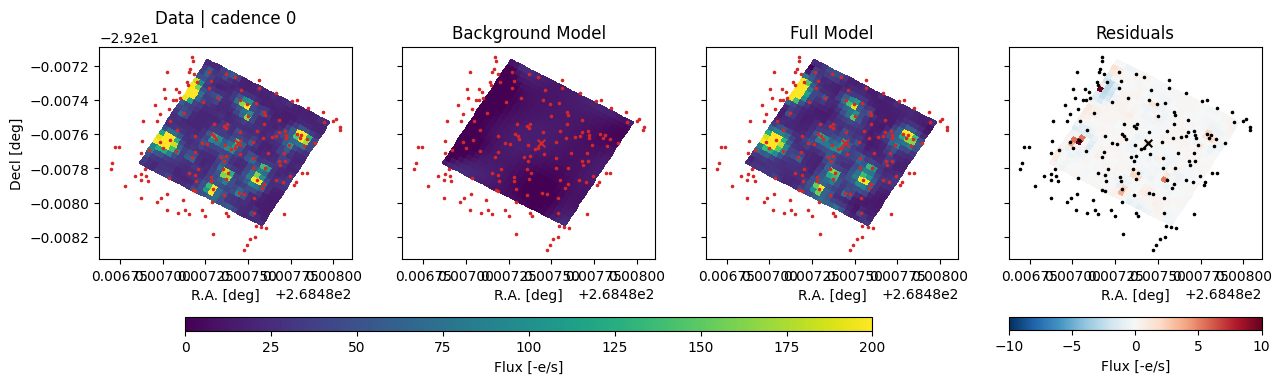

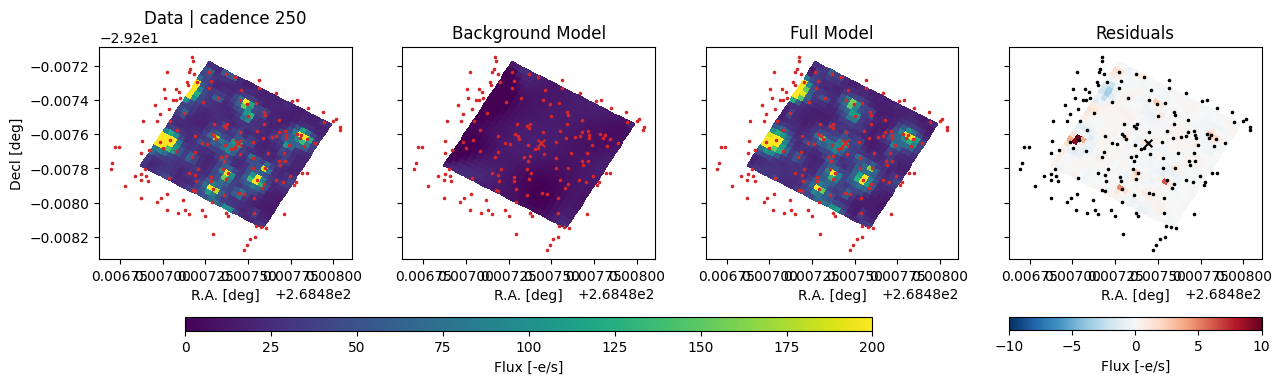

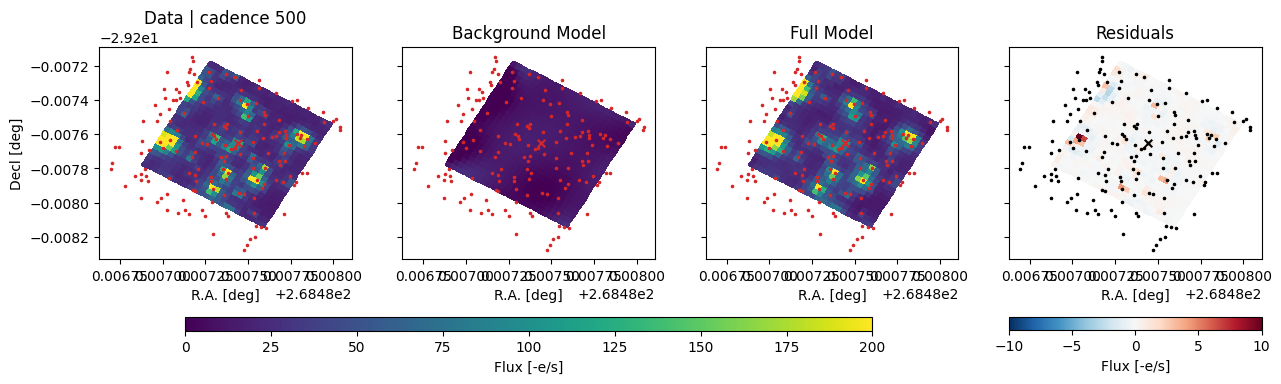

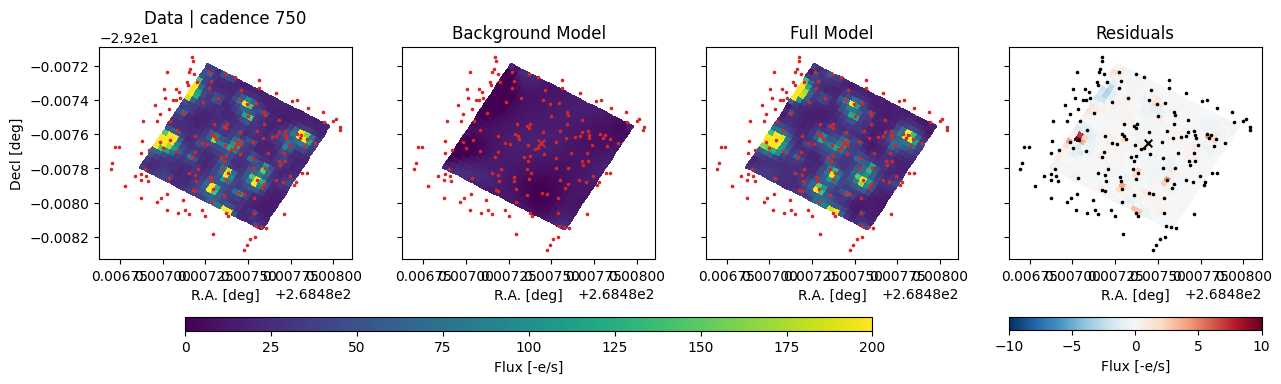

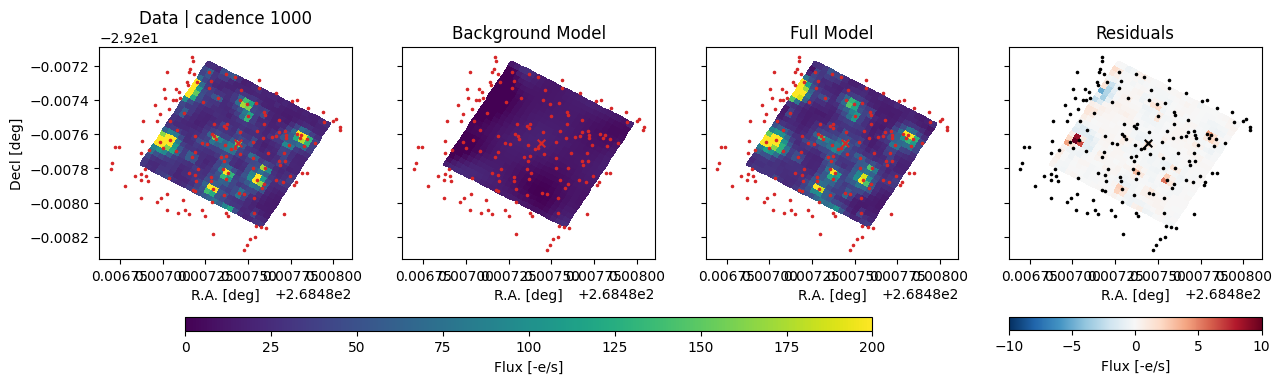

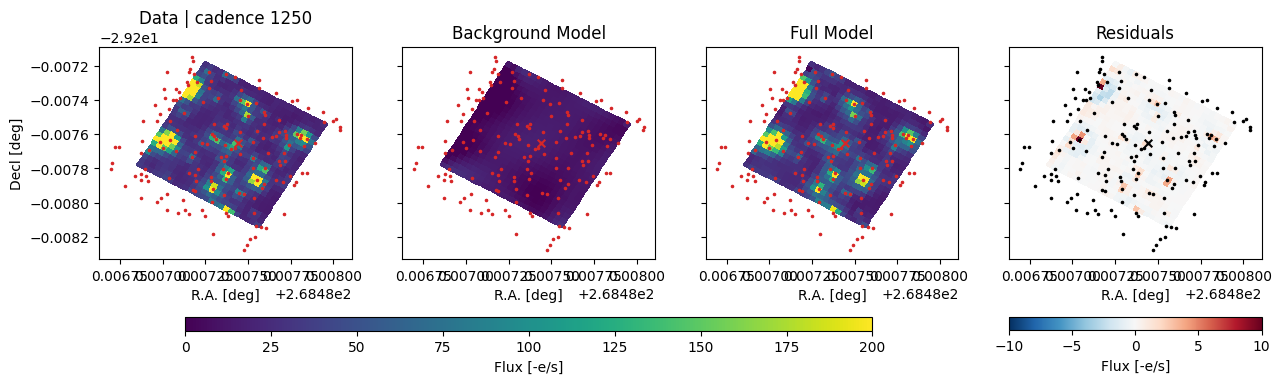

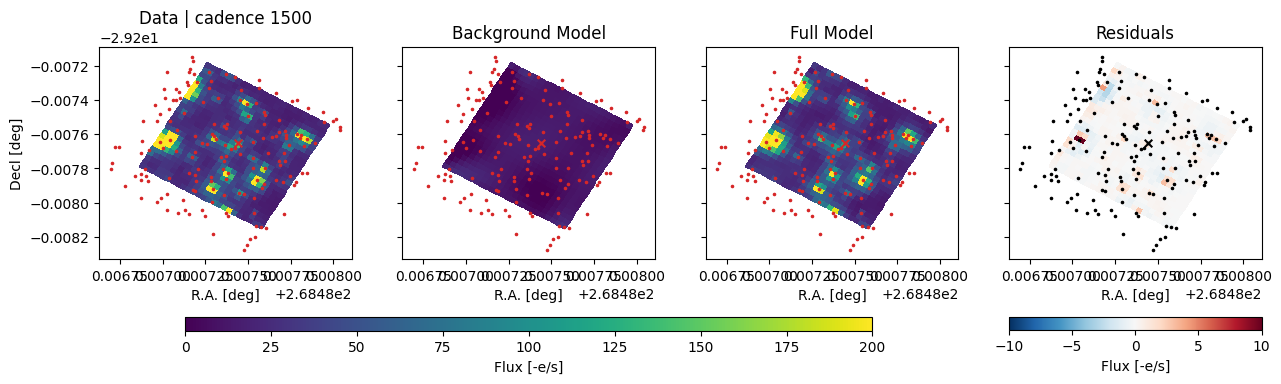

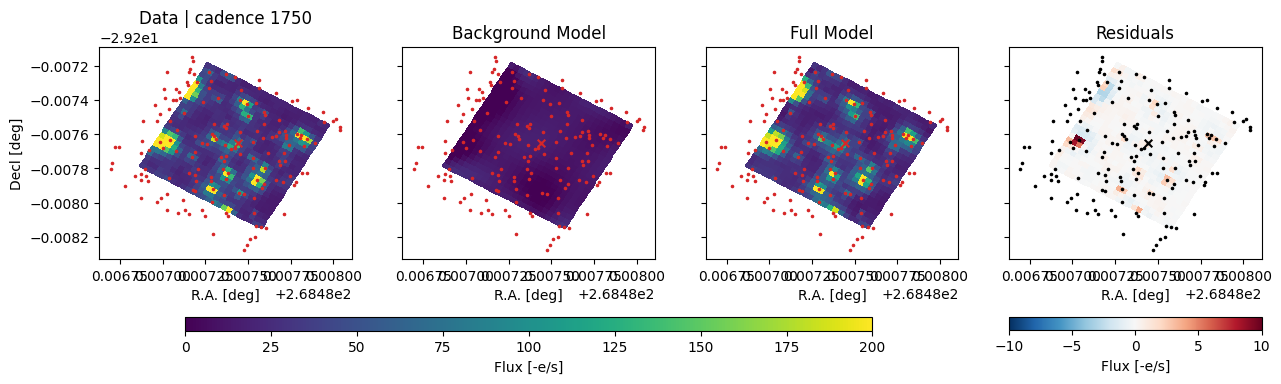

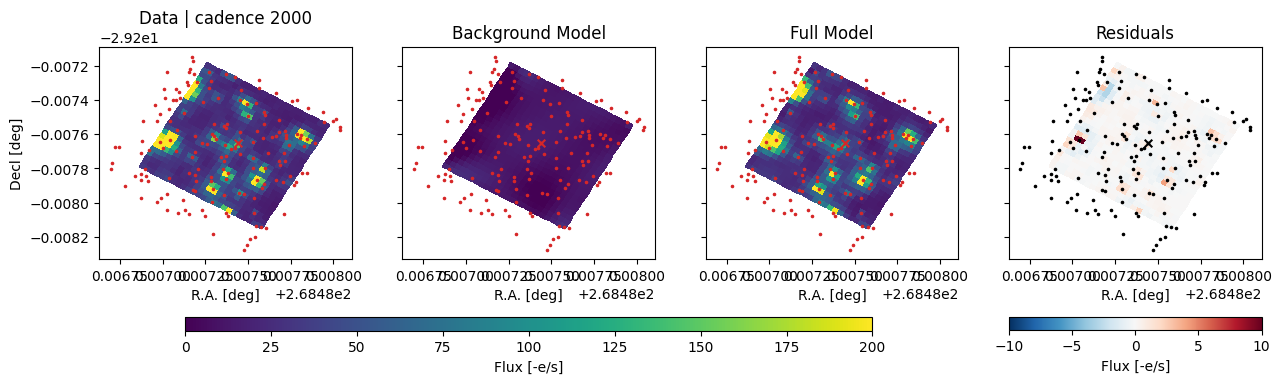

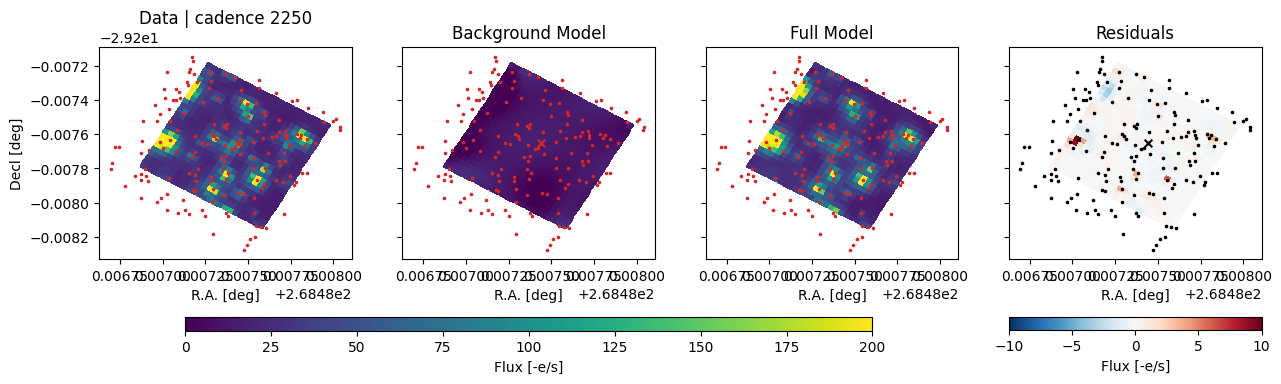

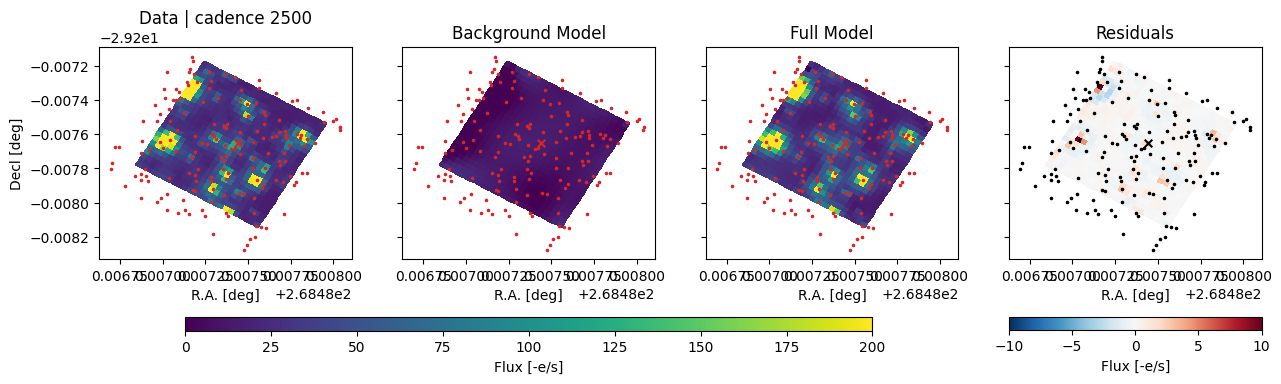

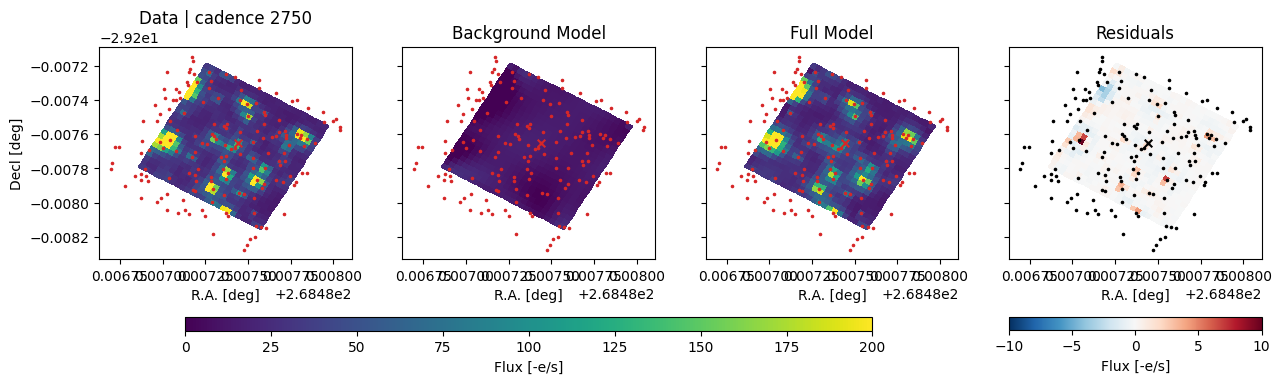

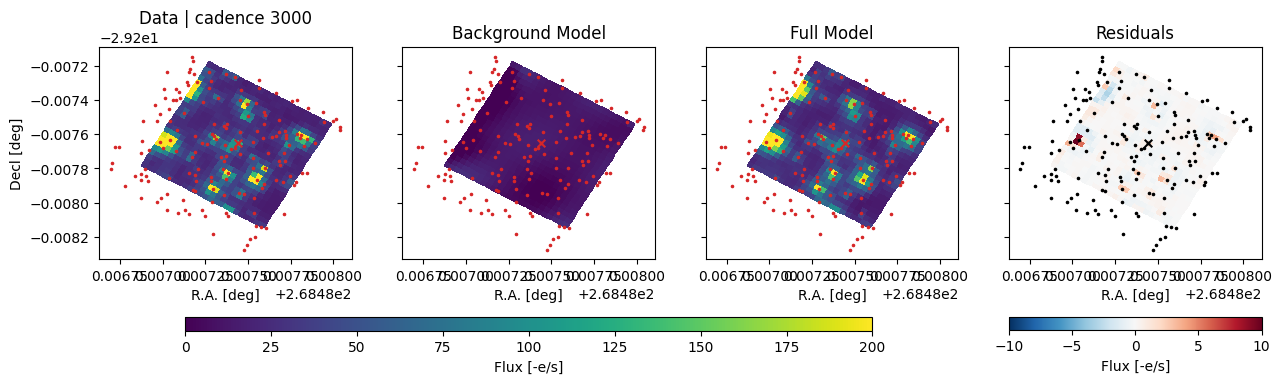

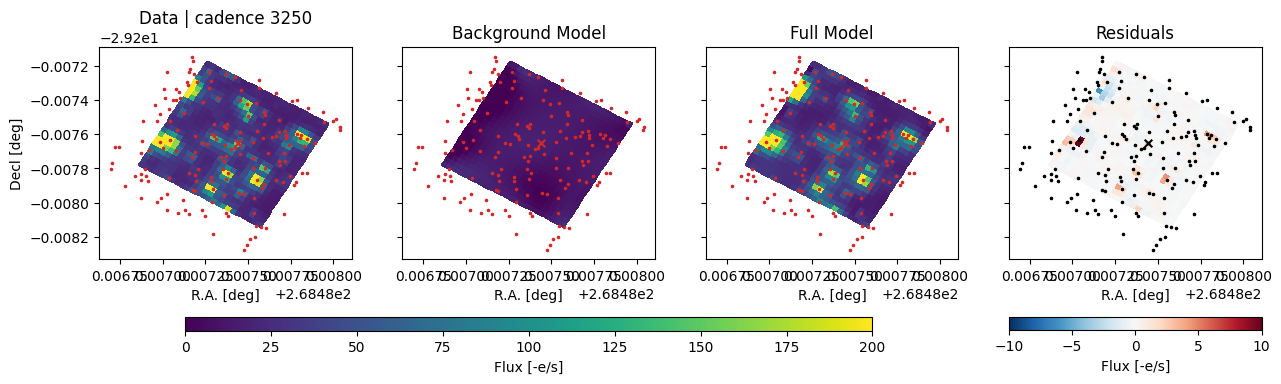

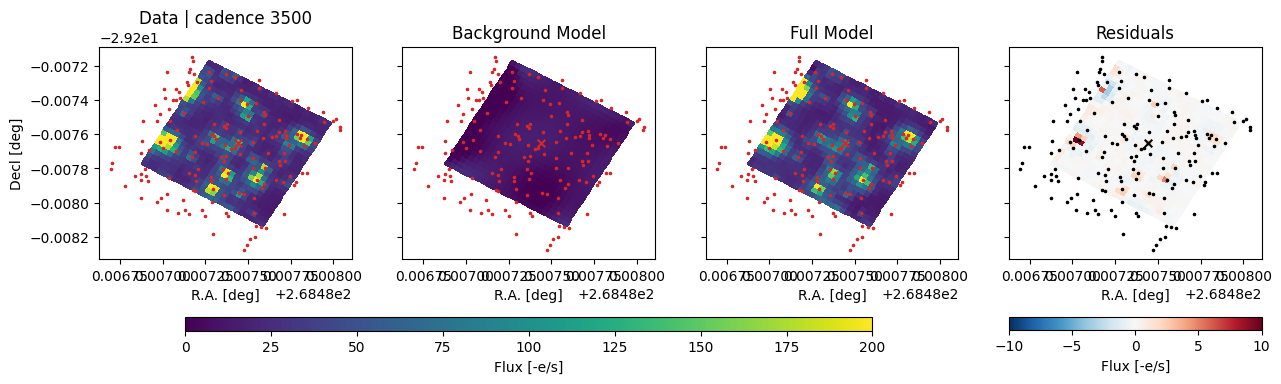

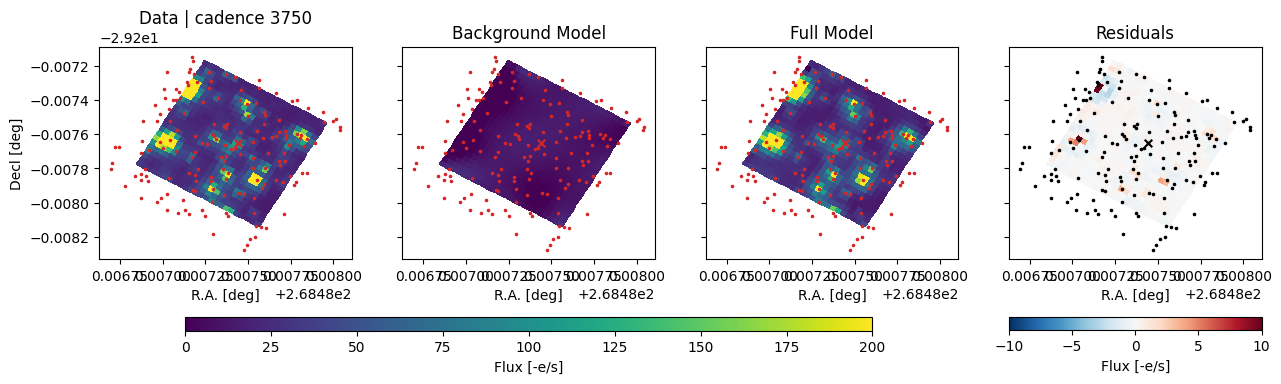

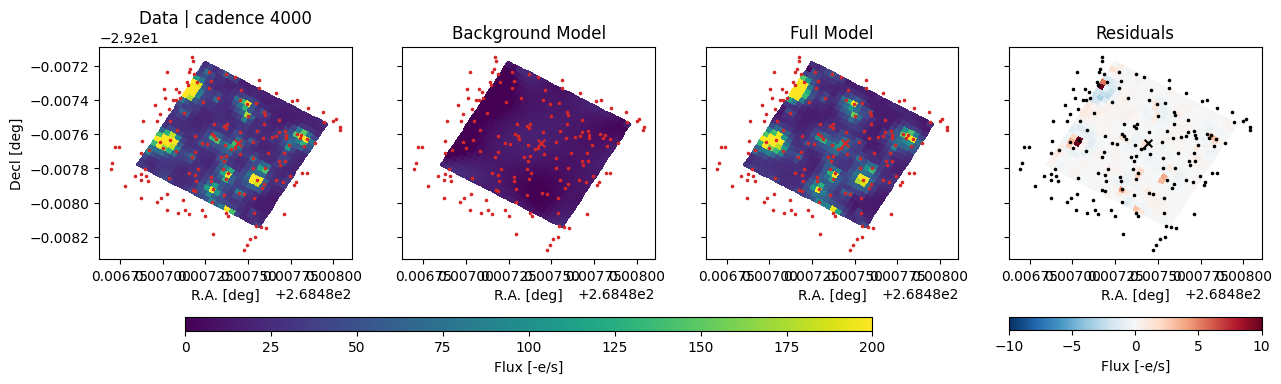

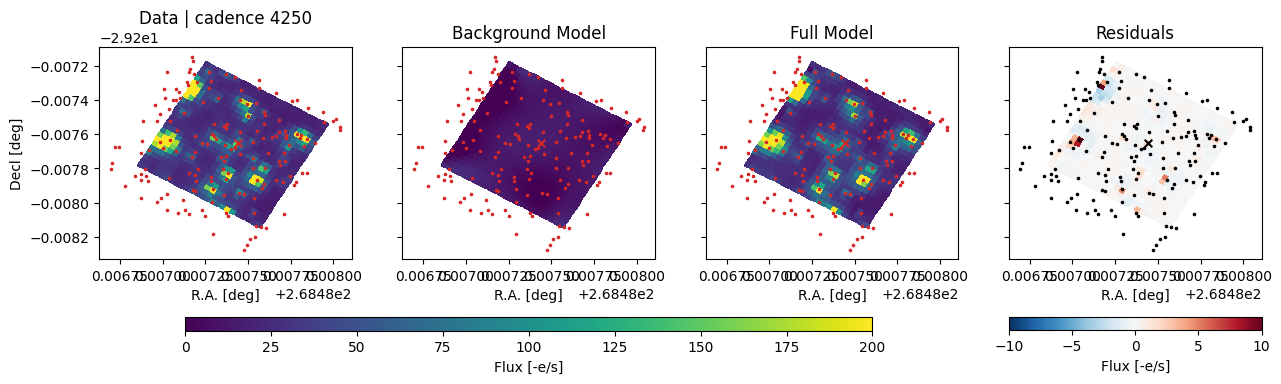

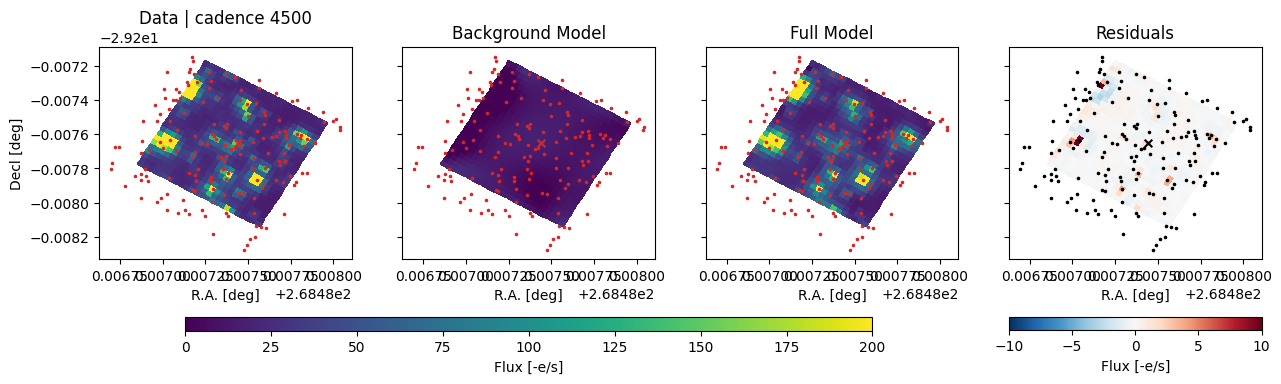

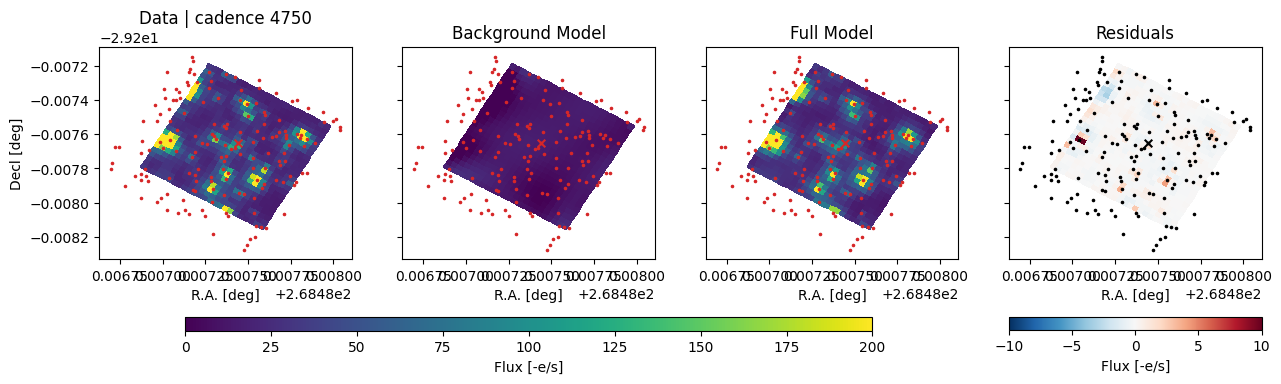

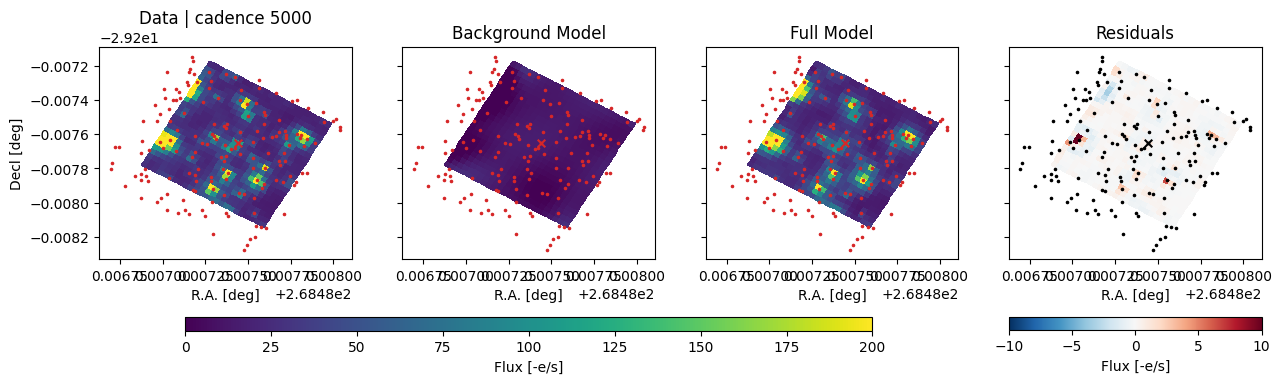

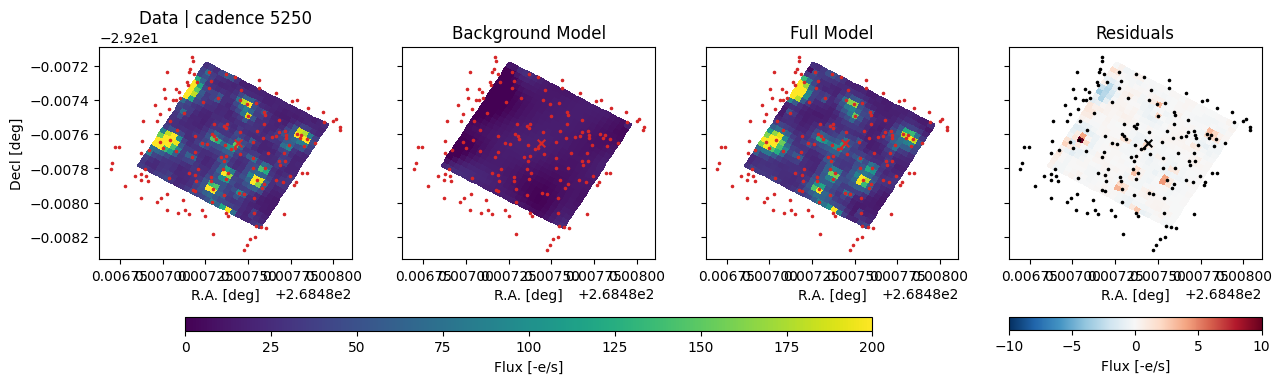

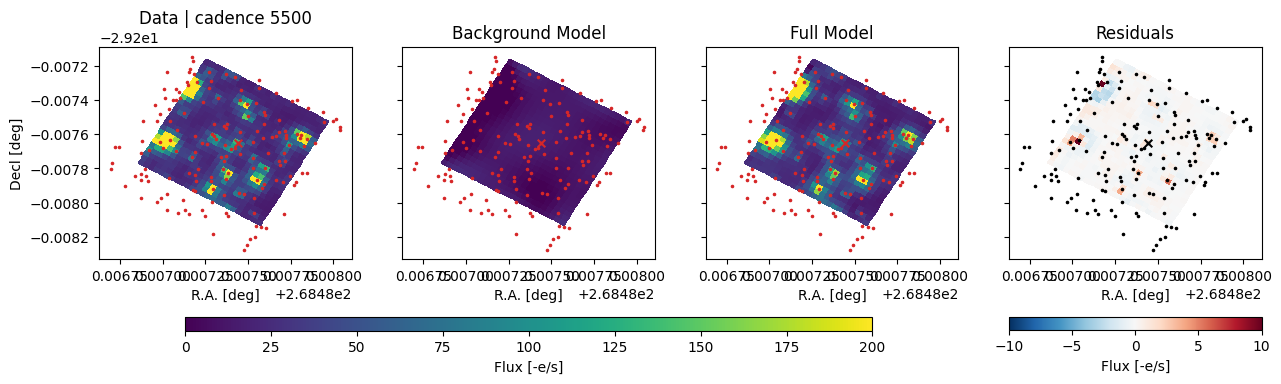

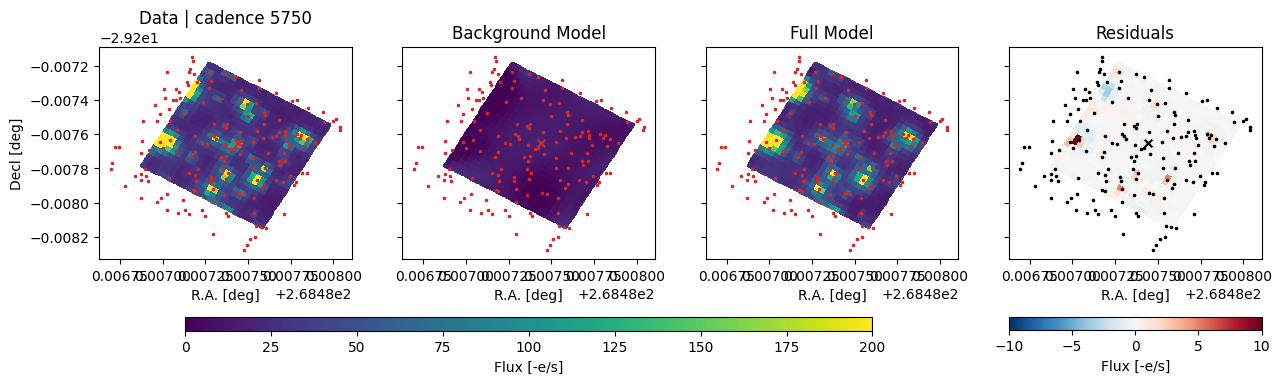

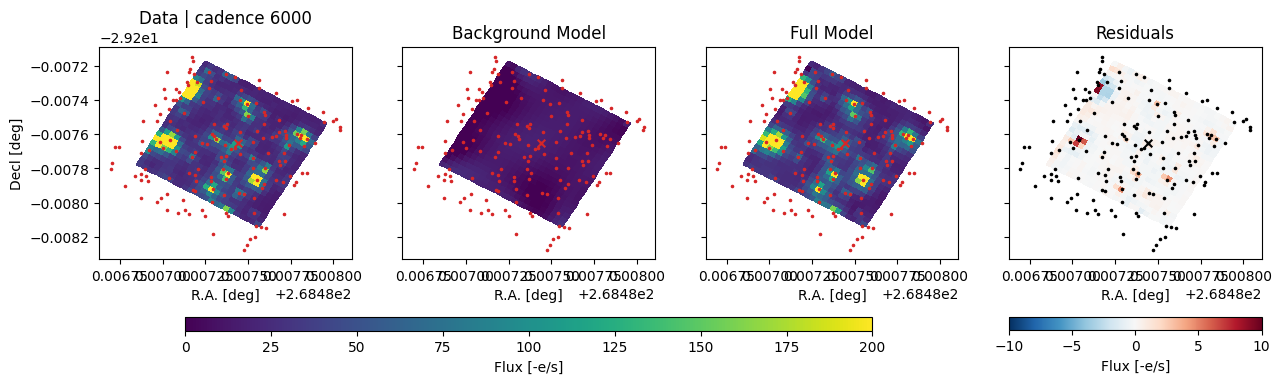

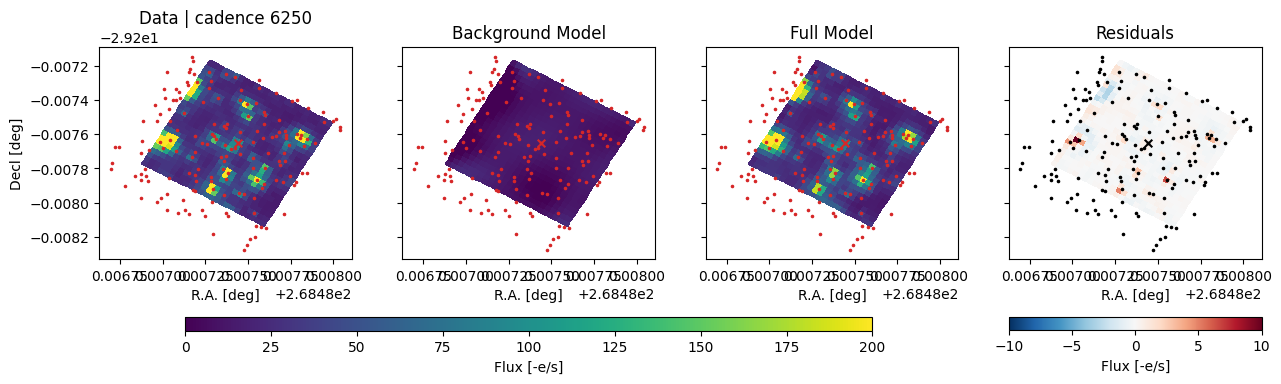

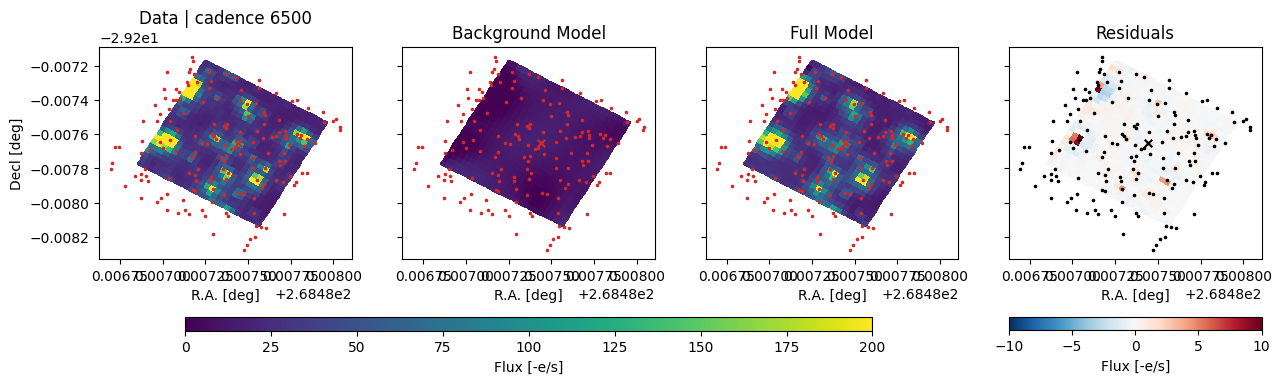

In [216]:
for tdx in range(0, mac.nt, 250):
    fig, ax = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)
    ax[0].set_title(f"Data | cadence {tdx}")
    cbar = ax[0].pcolormesh(
        mac.ra_3d[tdx],
        mac.dec_3d[tdx], 
        mac.flux_3d[tdx], 
        vmin=0, vmax=200,
    )
    ax[0].scatter(mac.sources.ra, mac.sources.dec, marker=".", s=10, color="tab:red")
    ax[0].scatter(mac.sources.ra[target_idx], mac.sources.dec[target_idx], marker="x", s=30, color="tab:red")
    ax[1].set_title(f"Background Model")
    ax[1].pcolormesh(
        mac.ra_3d[tdx],
        mac.dec_3d[tdx], 
        mac.bkg_model[tdx].reshape(mac.image_shape), 
        vmin=0, vmax=200,
    )
    ax[1].scatter(mac.sources.ra, mac.sources.dec, marker=".", s=10, color="tab:red")
    ax[1].scatter(mac.sources.ra[target_idx], mac.sources.dec[target_idx], marker="x", s=30, color="tab:red")
    ax[2].set_title(f"Full Model")
    ax[2].pcolormesh(
        mac.ra_3d[tdx],
        mac.dec_3d[tdx], 
        mac.scene_model[tdx].reshape(mac.image_shape), 
        vmin=0, vmax=200,
    )
    plt.colorbar(cbar, ax=ax[:3], orientation="horizontal", shrink=0.8, label="Flux [-e/s]", aspect=50)
    ax[2].scatter(mac.sources.ra, mac.sources.dec, marker=".", s=10, color="tab:red")
    ax[2].scatter(mac.sources.ra[target_idx], mac.sources.dec[target_idx], marker="x", s=30, color="tab:red")
    ax[3].set_title(f"Residuals")
    cbar = ax[3].pcolormesh(
        mac.ra_3d[tdx],
        mac.dec_3d[tdx], 
        (mac.flux_3d[tdx] - mac.scene_model[tdx].reshape(mac.image_shape))/20, 
        vmin=-10, vmax=10,
        cmap="RdBu_r",
    )
    plt.colorbar(cbar, ax=ax[3], orientation="horizontal", label="Flux [-e/s]")
    ax[3].scatter(mac.sources.ra, mac.sources.dec, marker=".", s=10, color="k")
    ax[3].scatter(mac.sources.ra[target_idx], mac.sources.dec[target_idx], marker="x", s=30, color="k")
    
    ax[0].set_ylabel("Decl [deg]")
    for axis in ax:
        axis.set_xlabel("R.A. [deg]")
        axis.set_aspect("equal", adjustable="box")
    plt.show()

And the extracted light curve:

In [230]:
mac.sources.iloc[target_idx[0]]

sicbro_id        4.579395e+06
ra               2.684874e+02
dec             -2.920765e+01
column           1.847044e+03
row              1.812984e+03
F062             2.183420e+01
F087             2.112730e+01
F106             2.080640e+01
F129             2.048540e+01
F158             2.026370e+01
F184             2.039350e+01
F213             2.052330e+01
F146             2.040430e+01
transitHost      1.000000e+00
dimEB            0.000000e+00
blendedEB        0.000000e+00
lowmassEB        0.000000e+00
lowRedNoise      1.000000e+00
hiRedNoise       0.000000e+00
variable         1.000000e+00
F087_flux        3.668822e+02
F087_flux_err    1.915417e+01
flux             7.140468e+02
flux_err         2.672165e+01
F213_flux        6.399215e+02
F213_flux_err    2.529667e+01
Name: 148, dtype: float64

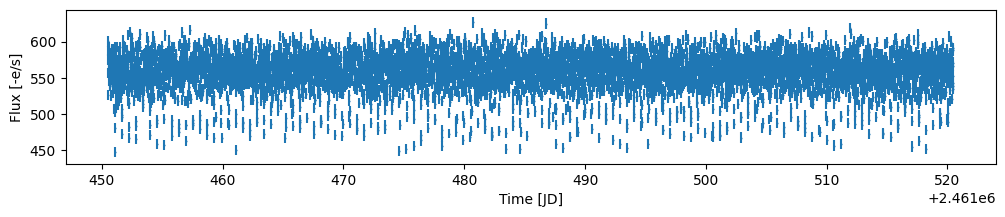

In [238]:
plt.figure(figsize=(12,2))
plt.errorbar(mac.time, mac.targets_prf_flux[:, 0], yerr=mac.targets_prf_flux_err[:, 0], fmt=".", ms=1)
plt.xlabel("Time [JD]")
plt.ylabel("Flux [-e/s]")
plt.show()

## Fit all sources

Here we fit all sources simultaneously, this improves efficiency but sacrifice precision and some objects (blends or extreme variables) could not have valid photometry, as we are fitting a more flexible model. 

In [220]:
mac.fit_model()

Fitting 166 Sources (w. VA): 100%|█████████████████████████████████████████████████████████| 6595/6595 [02:25<00:00, 45.32it/s]


In [221]:
# these variables have the flux and flux errors for every source [column] and frame [row]
mac.ws.shape, mac.werrs.shape

((6595, 166), (6595, 166))

We set the problem as a system of linear equations like `Ax = y` with `A` a square matrix that is built from the PRF model evaluated in the pixel grid of all sources to get a mean model, `y` is the pixel values in the image, and solving for `x`. Negative solutions for `x` are matematically allowed within the range of the priors we set (the catalog flux values). 
We could improve this by narrowing the priors for sources with negative fluxes, `mac.fit_model()` has arguments that controls the mean and variance of the priors.

Here's the light curve for our eclipsing target above. Note that the light curve is noisier. 

In [235]:
mac.ws[:, target_idx[0]].mean()

846.0172869430065

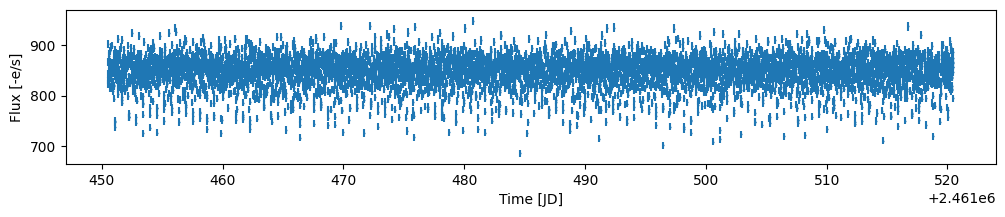

In [242]:
plt.figure(figsize=(12,2))
plt.errorbar(mac.time, mac.ws[:, target_idx[0]], yerr=mac.werrs[:, target_idx[0]], ms=1, fmt=".")
plt.xlabel("Time [JD]")
plt.ylabel("Flux [-e/s]")
plt.show()

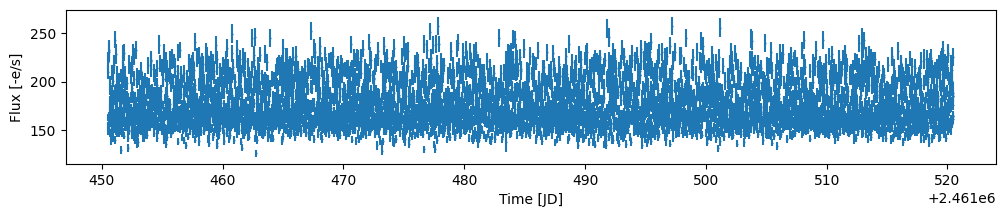

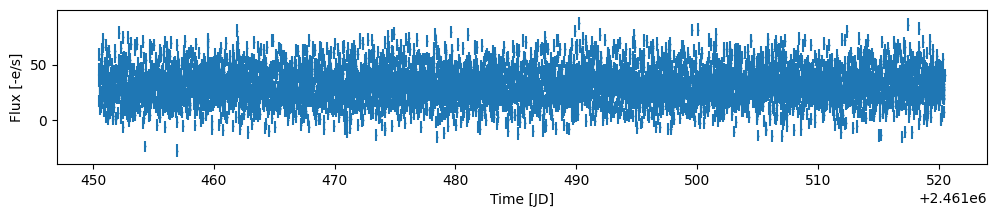

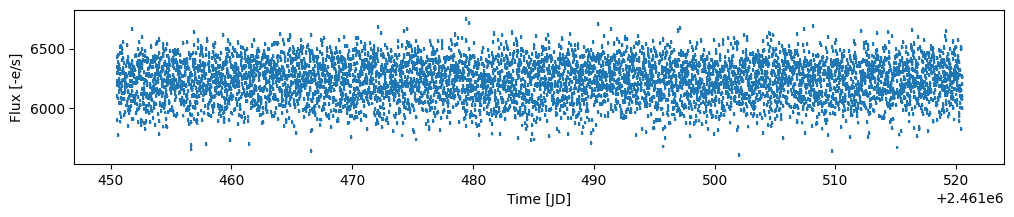

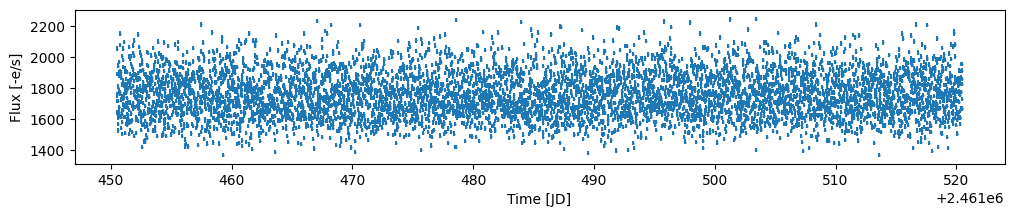

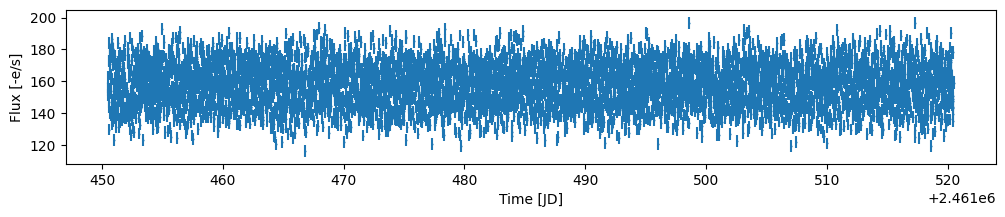

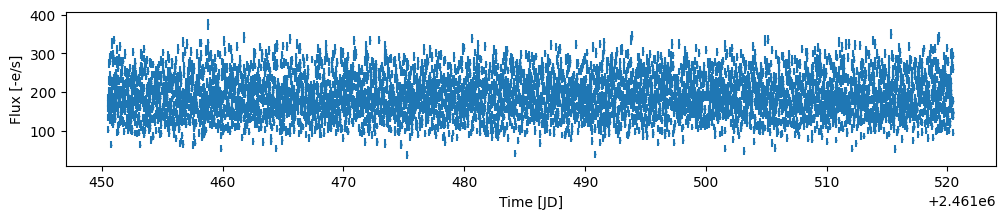

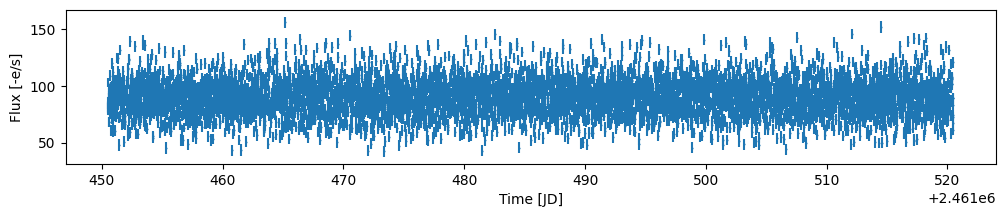

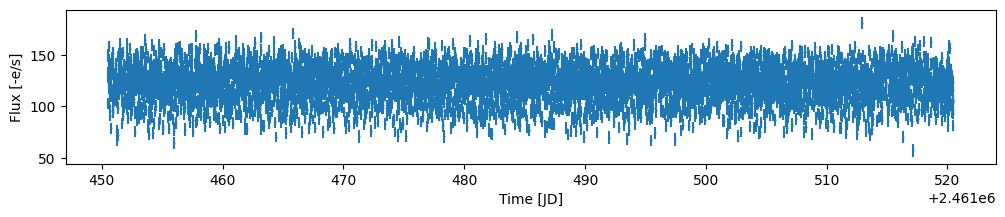

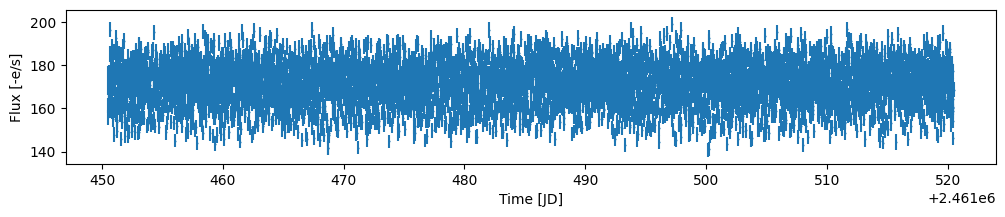

In [246]:
for k in mac.sources.sample(20, replace=False).index.values:
    if (mac.ws[:, k] < 0).sum() / mac.nt > 0.5 or np.isnan(mac.ws[:, k]).all(): continue
    plt.figure(figsize=(12,2))
    plt.errorbar(mac.time, mac.ws[:, k], yerr=mac.werrs[:, k], ms=1, fmt=".")
    plt.xlabel("Time [JD]")
    plt.ylabel("Flux [-e/s]")
    plt.show()

Now we can save the light curves to FITS files: